In [2]:
import pandas as pd
import pickle
import os
from keras.models import load_model
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import sys
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Embedding, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import keras.backend as K
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score,ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-07-23 15:55:20.144221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 15:55:20.164791: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 15:55:20.164936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
import code_tokenize
import re
def my_tokenizer(text):
    text = re.sub(r'\b\d+\.\d+\b', lambda x: str(float(x.group())), text)
    tokens = code_tokenize.tokenize(text, lang="c", syntax_error="ignore")
    tokens_list = [str(x) for x in tokens]
    return tokens_list

In [5]:
# tokenize the data that can be used by embeddings
#import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import os
import pickle
import time


tokenizer_path = "/home/irshad/Documents/Vuldetect/tokenizer/tokenizer.pkl"
retrain = False
if os.path.exists(tokenizer_path) and not retrain:
    print("[INFO] Loading saved tokenizer")
    with open(tokenizer_path, "rb") as tokenizer_file:
        tokenizer = pickle.load(tokenizer_file)
else:
    t0 = time.time()
    print("[INFO] fitting tokenizer on TRAIN data...")
    tokenizer = Tokenizer(lower=False, analyzer = my_tokenizer)  # used in the research paper
    tokenizer.fit_on_texts(X_train.apply(lambda x: np.str_(x)))
    # save the tokenizer for future use
    with open(tokenizer_path, "wb") as tokenizer_file:
        pickle.dump(tokenizer, tokenizer_file, protocol=pickle.HIGHEST_PROTOCOL)
        # pickle.HIGHEST_PROTOCOL is highest protocol version available
    print(f"time taken to fit and save the tokenizer: {time()-t0} s")   

[INFO] Loading saved tokenizer


In [6]:
def tokenize_sequences(X_train, X_test, X_val, tokenizer):
    X_train = [str(code) for code in X_train]  # Convert any non-string elements to string
    X_train = tokenizer.texts_to_sequences(X_train)

    X_val = [str(code) for code in X_val]  # Convert any non-string elements to string
    X_val = tokenizer.texts_to_sequences(X_val)

    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)

    max_length_train = max(len(sequence) for sequence in X_train)
    max_length_val = max(len(sequence) for sequence in X_val)
    max_length_test = max(len(sequence) for sequence in X_test)

    maxlen = 1000

    X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
    X_val = pad_sequences(X_val, padding="post", maxlen=maxlen)
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

    return X_train, X_val, X_test

In [7]:
def tokenize_test_sequences(X_test, tokenizer):
    X_test = [str(code) for code in X_test]  # Convert any non-string elements to string
    X_test = tokenizer.texts_to_sequences(X_test)
    maxlen = 1000
    X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)
    return X_test

In [8]:
def load_data():
    df = pd.read_csv('/home/irshad/Documents/Vuldetect_Source_code/My_code/notebook/diversevul_dataset/preprocessed_df_100k.csv')
    df_target_0 = df[df['target'] == 0].head(35000)
    df_target_1 = df[df['target'] == 1]
    
    # df_filtered = pd.concat([df_target_0, df_target_1], ignore_index=True)
    # print(df_filtered.target.value_counts())
    X_train, X_test, y_train, y_test = train_test_split(
        df['func'],
        df['target'],
        test_size=0.2,
        random_state=42,
        stratify=df['target']
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.1,
        random_state=42,
        stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

In [10]:
test_padded = tokenize_test_sequences(X_test, tokenizer)

/home/irshad/anaconda3/envs/tensorflow_env/lib/python3.9/site-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model

def predict_and_compile(model_paths, X_test, y_test):
    
    # Load models from the given paths
    lstm_model = load_model(model_paths[0])
    gru_model = load_model(model_paths[1])
    bi_lstm_model = load_model(model_paths[2])

    # Predict probabilities using each model
    lstm_prob = lstm_model.predict(X_test)
    gru_prob = gru_model.predict(X_test)
    bi_lstm_prob = bi_lstm_model.predict(X_test)

    # Ensure y_test is a 1D array
    if y_test.ndim > 1:
        y_test = y_test.ravel()

    # Initialize a DataFrame with the actual test labels
    df = pd.DataFrame({'y_test': y_test})
    
    # Add predicted probabilities to the DataFrame
    df['lstm_class_0'] = lstm_prob[:, 0]
    df['lstm_class_1'] = lstm_prob[:, 1]
    df['gru_class_0'] = gru_prob[:, 0]
    df['gru_class_1'] = gru_prob[:, 1]
    df['bi_lstm_class_0'] = bi_lstm_prob[:, 0]
    df['bi_lstm_class_1'] = bi_lstm_prob[:, 1]
    
    return df

# Example usage:
# Paths to the saved models
lstm_model_path = '/home/irshad/Documents/Vuldetect/models/LSTM_w2v_50.keras'
gru_model_path = '/home/irshad/Documents/Vuldetect/models/GRU_w2v_50.keras'
bi_lstm_model_path = '/home/irshad/Documents/Vuldetect/models/BILSTM_w2v_50.keras'

# Model paths list
model_paths = [lstm_model_path, gru_model_path, bi_lstm_model_path]

# Call the function
result_df = predict_and_compile(model_paths, test_padded, y_test)

# Print the result
print(result_df.head())



2024-07-21 00:28:44.054879: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 00:28:44.056877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 00:28:44.057082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-21 00:28:44.057160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

  3/744 [..............................] - ETA: 19s  

2024-07-21 00:28:46.613224: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2024-07-21 00:28:46.743740: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


744/744 [==============================] - 58s 77ms/step
       y_test  lstm_class_0  lstm_class_1  gru_class_0  gru_class_1  \
39037       0      0.999916      0.000084     0.945302     0.054698   
64823       0      0.998783      0.001217     0.996465     0.003535   
48257       0      0.999636      0.000364     0.995819     0.004181   
11912       1      0.737528      0.262472     0.994827     0.005173   
18184       1      0.000038      0.999962     0.000006     0.999994   

       bi_lstm_class_0  bi_lstm_class_1  
39037     9.996166e-01         0.000383  
64823     9.927313e-01         0.007269  
48257     9.999850e-01         0.000015  
11912     2.822918e-06         0.999997  
18184     1.719278e-08         1.000000  


In [13]:
result_df.to_csv('/home/irshad/Documents/Vuldetect/stacked_data_100k.csv')

In [11]:
df = pd.read_csv('/home/irshad/Documents/Vuldetect/stacked_data_100k.csv')

In [12]:
df.head()

,Unnamed: 0,y_test,lstm_class_0,lstm_class_1,gru_class_0,gru_class_1,bi_lstm_class_0,bi_lstm_class_1
0,39037,0,0.999916,0.000084,0.945302,0.054698,9.996166e-01,0.000383
1,64823,0,0.998783,0.001217,0.996465,0.003535,9.927313e-01,0.007269
2,48257,0,0.999636,0.000364,0.995819,0.004181,9.999850e-01,0.000015
3,11912,1,0.737528,0.262472,0.994827,0.005173,2.822918e-06,0.999997
4,18184,1,0.000038,0.999962,0.000006,0.999994,1.719278e-08,1.000000


In [13]:
df.y_test.value_counts()

y_test
0    20000
1     3789
Name: count, dtype: int64

Epoch 1/30


2024-07-23 15:57:22.282019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 15:57:22.284913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 15:57:22.285120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-23 15:57:22.285235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

 75/270 [=======>......................] - ETA: 0s - loss: 0.3654 - accuracy: 0.8558

2024-07-23 15:57:22.728015: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


270/270 [==============================] - 1s 3ms/step - loss: 0.2066 - accuracy: 0.9189 - val_loss: 0.0979 - val_accuracy: 0.9685
Epoch 2/30
270/270 [==============================] - 1s 3ms/step - loss: 0.0714 - accuracy: 0.9754 - val_loss: 0.0523 - val_accuracy: 0.9829
Epoch 3/30
270/270 [==============================] - 0s 2ms/step - loss: 0.0455 - accuracy: 0.9864 - val_loss: 0.0367 - val_accuracy: 0.9898
Epoch 4/30
270/270 [==============================] - 1s 3ms/step - loss: 0.0346 - accuracy: 0.9903 - val_loss: 0.0296 - val_accuracy: 0.9912
Epoch 5/30
270/270 [==============================] - 1s 3ms/step - loss: 0.0286 - accuracy: 0.9919 - val_loss: 0.0240 - val_accuracy: 0.9935
Epoch 6/30
270/270 [==============================] - 1s 2ms/step - loss: 0.0245 - accuracy: 0.9930 - val_loss: 0.0217 - val_accuracy: 0.9958
Epoch 7/30
270/270 [==============================] - 1s 3ms/step - loss: 0.0225 - accuracy: 0.9930 - val_loss: 0.0184 - val_accuracy: 0.9930
Epoch 8/30
270/27

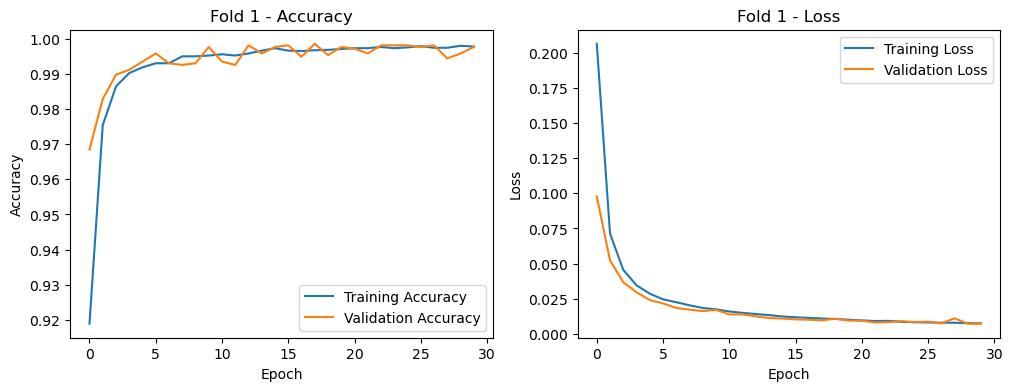

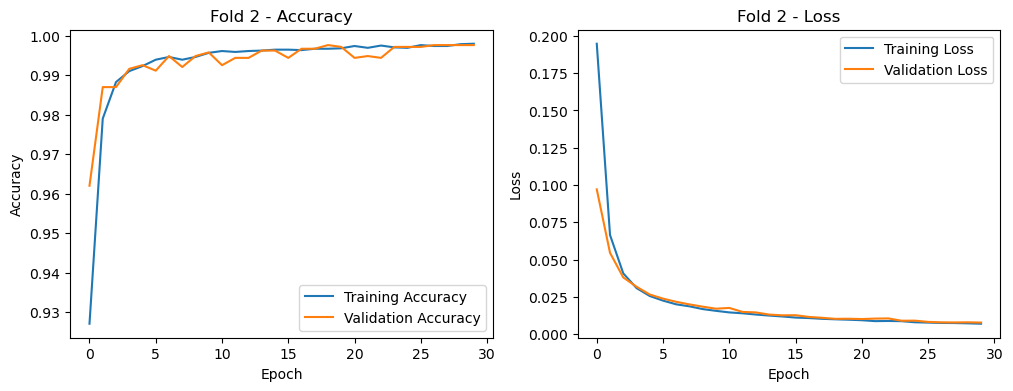

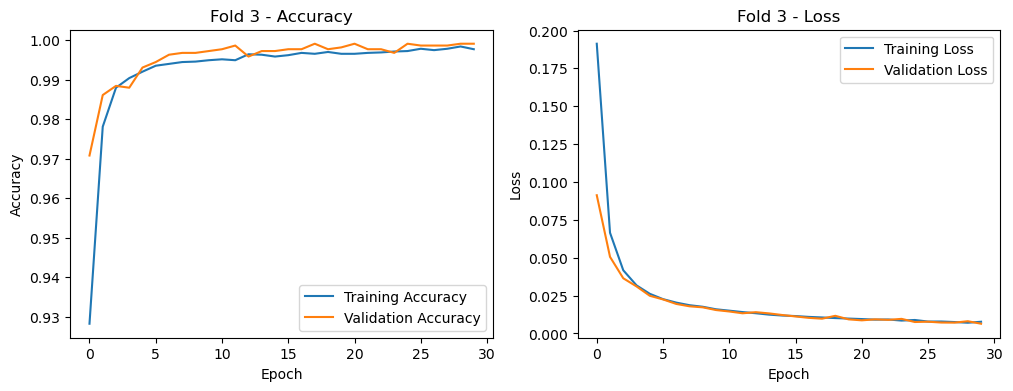

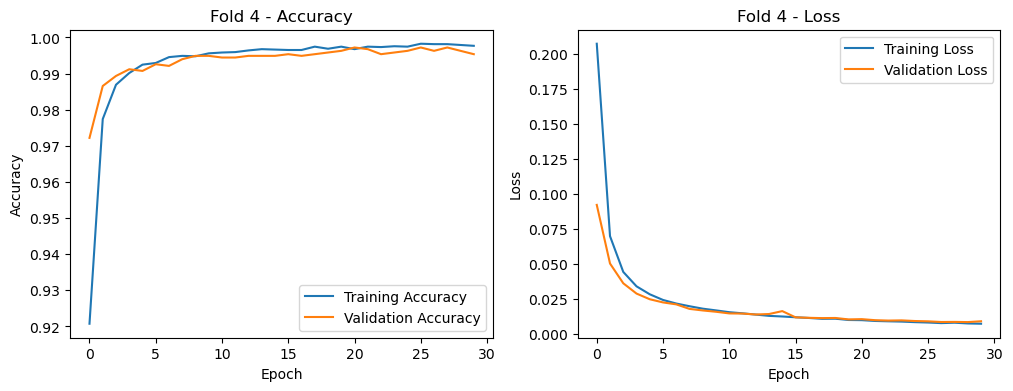

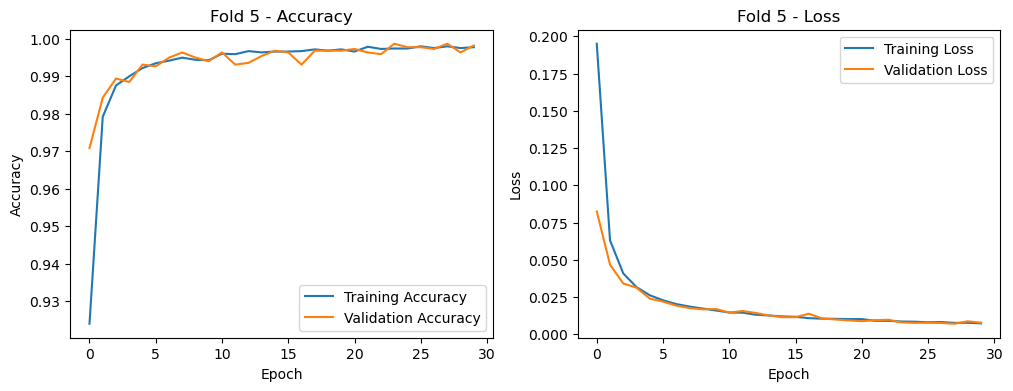

Average Loss: 0.0076, Average Accuracy: 0.9976
Best Fold Accuracy: 0.9991


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


df = pd.read_csv('/home/irshad/Documents/Vuldetect/stacked_data.csv')  
X = df.drop('y_test', axis=1).values
y = df['y_test'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Lists to store the scores for each fold
losses = []
accuracies = []
histories = []

# Define your model creation function
def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X.shape[1],)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Train and evaluate the model on each fold
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    model = create_model()
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)
    
    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    losses.append(loss)
    accuracies.append(accuracy)
    histories.append(history.history)
    
    print(f'Fold {fold + 1} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# Plot the training and validation accuracy/loss for each fold
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

# Print the final results
average_loss = np.mean(losses)
average_accuracy = np.mean(accuracies)

print(f'Average Loss: {average_loss:.4f}, Average Accuracy: {average_accuracy:.4f}')
print(f'Best Fold Accuracy: {np.max(accuracies):.4f}')

